# Run image through a pretrained network
Try running an image through trained YOLO network from boto without downloading

In [1]:
import sagemaker
import boto3
import glob
import os
import s3fs
import shutil 
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt

Use a pretrained YOLO model to start

In [2]:
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

Create a session and role. Then specify the bucket and download a few images.

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
s3 = boto3.resource('s3')

# the bucket name and list
bucket = s3.Bucket('orange-roughy')
ptf = 'ML_data/OP12/port/images/'

# save the file in the specified bucket to a list
obj_list = []
for obj in bucket.objects.filter(Delimiter='/', Prefix=ptf):
  obj_list.append(obj.key)

Create a local temporary directory and load in a few images from the s3 bucket specified above.

In [4]:
# create a temporary directory
tempdir = os.path.join(os.getcwd(), 'temp')
if not os.path.exists(tempdir):
    os.mkdir(tempdir)

new_imgs = []
# save images to a temporary local directory
for img in obj_list[0:20]:
    img_local = os.path.join(tempdir, os.path.basename(img))
    new_imgs.append(img_local)
    bucket.download_file(img, img_local)

Pick an image and try to detect objects in it with YOLO. 

Run the transform to get the images into the appropriate format for running through the classifier. Returns a list of the transformed images and another list of the untransformed images.

In [5]:
xx, yy = data.transforms.presets.yolo.load_test(new_imgs, short=512)

# print the length of the list (should match the number of images in the temp directory)
print('The number of loaded images is:', len(xx))

# transformed image shape
print('Shape of first pre-processed image:', xx[0].shape)

# original shape
print('Shape of first original image:', yy[0].shape)

The number of loaded images is: 20
Shape of first pre-processed image: (1, 3, 512, 683)
Shape of first original image: (512, 683, 3)


Now run the network forward with the set of transformed images

In [6]:
class_IDs, scores, bounding_boxs = net(xx[11])

Now use gluon's visualization tool to check the output (probably not much without fine tuning)

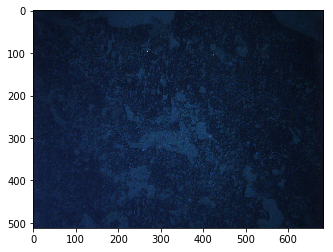

In [7]:
# make sure the index of the image to display matches that of the input image above
ax = utils.viz.plot_bbox(yy[11], bounding_boxs[0], scores[0], class_IDs[0], class_names=net.classes)

plt.show()

Remove the temporary directory.

In [8]:
shutil.rmtree(os.path.join(os.getcwd(), 'temp'))